In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from cub2011 import Cub2011

import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

In [5]:
# Remove files ending with 'Zone.Identifier' in the data directory
directory = 'data'

for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith('Zone.Identifier'):
            file_path = os.path.join(root, filename)
            os.remove(file_path)

In [6]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the FGVAC Aircraft dataset
train_aircraft_data = datasets.FGVCAircraft(root='data', download=False, transform=transform, split='train')
val_aircraft_data = datasets.FGVCAircraft(root='data', download=False, transform=transform, split='val')
test_aircraft_data = datasets.FGVCAircraft(root='data', download=False, transform=transform, split='test')

In [7]:
# Create the Aircraft DataLoader
train_aircraft_dataloader = torch.utils.data.DataLoader(train_aircraft_data, batch_size=32, shuffle=True)
val_aircraft_dataloader = torch.utils.data.DataLoader(val_aircraft_data, batch_size=32, shuffle=True)
test_aircraft_dataloader = torch.utils.data.DataLoader(test_aircraft_data, batch_size=32, shuffle=True)

In [10]:
train_bird_data = Cub2011(root='data', train=True, transform=transform, download=False)

# Split train_bird_data into training and validation sets
train_size = int(0.8 * len(train_bird_data))
val_size = len(train_bird_data) - train_size
train_bird_data, val_bird_data = torch.utils.data.random_split(train_bird_data, [train_size, val_size])

test_bird_data = Cub2011(root='data', train=False, transform=transform, download=False)

In [11]:
# Create the bird DataLoader
train_bird_dataloader = torch.utils.data.DataLoader(train_bird_data, batch_size=32, shuffle=True)
val_bird_dataloader = torch.utils.data.DataLoader(val_bird_data, batch_size=32, shuffle=True)
test_bird_dataloader = torch.utils.data.DataLoader(test_bird_data, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


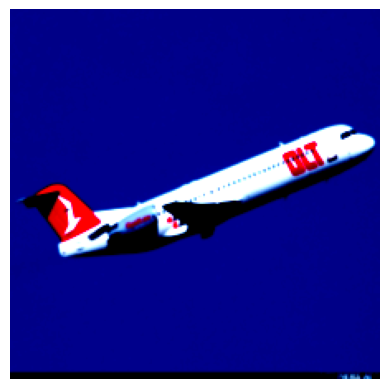

In [5]:
# Get the first batch of images and labels from the train_dataloader
images, labels = next(iter(train_aircraft_dataloader))

# Show the first image
plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


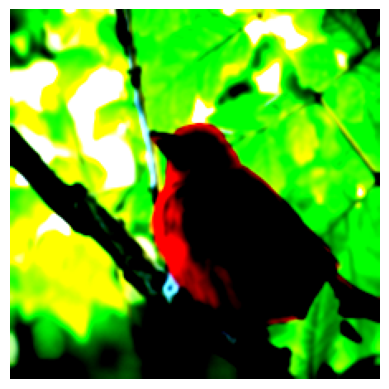

In [12]:
# Get the first batch of images and labels from the train_dataloader
images, labels = next(iter(train_bird_dataloader))

# Show the first image
plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.axis('off')
plt.show()

In [6]:
# Define the ResNet model
model = resnet50(pretrained=True)
num_classes = len(train_aircraft_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_aircraft_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * images.size(0)

    train_accuracy = train_correct / len(train_aircraft_dataloader.dataset)
    train_loss = train_loss / len(train_aircraft_dataloader.dataset)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_aircraft_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item() * images.size(0)

    val_accuracy = val_correct / len(val_aircraft_dataloader.dataset)
    val_loss = val_loss / len(val_aircraft_dataloader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test set
model.eval()
test_correct = 0

with torch.no_grad():
    for images, labels in test_aircraft_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / len(test_aircraft_dataloader.dataset)

print(f"Test Accuracy: {test_accuracy:.4f}")


/home/posiedon72/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/posiedon72/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
